# E-Bike Stopping Distances

How far will an e-bike skid before coming to a complete stop?

In this project I have modeled the relationship between speeds and stopping distances for electric bicycles.

The main file for this project is `ebike-stopping-distances.csv`. This contains distances an e-bike traveled before coming to a complete stop after slamming both front and rear brakes. These experiments were conducted on a gravel road.

In [80]:
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 10)
df = pd.read_csv('ebike-stopping-distances.csv')
df #display the dataframe

,speed,distance
0,15.4,3.6
1,16.2,3.8
2,17.2,4.3
3,19.4,5.1
4,25.7,7.6
5,26.8,8.5
6,32.6,9.9
7,34.7,11.9
8,36.3,14.2


The fastest speed in this data is 36.3 kilometers per hour, where the e-bike took 14.2 meters to come to a complete stop.

### Visualizing the Data
Let's quickly visualize the relationship between speed and stopping distance. A scatter plot is a good choice.

Since speed predicts stopping distance, we'll place speed along the x axis.

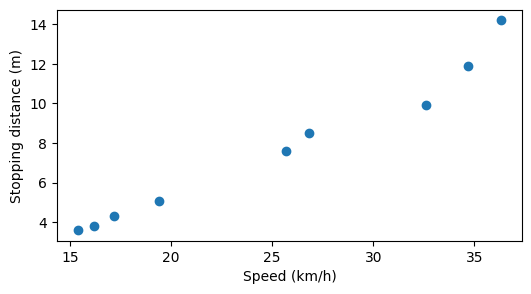

In [81]:
plt.figure(figsize=(6, 3))
plt.scatter(df['speed'], df['distance'])
plt.xlabel('Speed (km/h)')
plt.ylabel('Stopping distance (m)')
plt.show()

As speed increases, stopping distance also increases.

Let's build a mathematical model to describe the relationship between these two variables. Let's start by fitting a simple linear model.

### Fitting a Linear model

I've created the following python class to use as our Linear Model. 

This class leverages the scikit-learn library to fit a line to x and y data using linear regression. 

In [82]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

class LinearModel:
    def __init__(self, model_name=""):
        self.model_name = model_name
        
    def fit(self, x, y):
        x = pd.DataFrame(x)
        linear_model = LinearRegression().fit(x, y)
        y_pred = linear_model.predict(x)
        self.slope = linear_model.coef_[0]
        self.intercept = linear_model.intercept_
        self.rsquared = r2_score(y, y_pred)
        
    def predict(self, x):
        return self.slope * x + self.intercept

    def plot_model(self, x_min, x_max, color="black"):
        y_min = self.predict(x_min)
        y_max = self.predict(x_max)
        plt.plot([x_min, x_max], [y_min, y_max], color=color)
        
    def print_model_info(self):
        m = self.slope
        b = self.intercept
        rsquared = self.rsquared
        model_name = self.model_name
        print(f'LinearModel({model_name}):')
        print(f'Parameters: slope = {m:.2f}, intercept = {b:.2f}')
        print(f'Equation: y = {m:.2f}x + {b:.2f}')
        print(f'Goodness of Fit (R²): {rsquared:.3f}')

Let's use this LinearModel class to fit our stopping distance data.

In [83]:
linear = LinearModel()
linear.fit(x=df['speed'], y=df['distance'])
linear.print_model_info()

LinearModel():
Parameters: slope = 0.45, intercept = -3.64
Equation: y = 0.45x + -3.64
Goodness of Fit (R²): 0.968


From the model parameters we see that the best fitting line has a slope of 0.45. The goodness of fit metric (R²) indicates that 96.8% of the variance is explained by the model, which is a very good fit.

Let's use the `plot_model( )` method to get a visual sense for the quality of this model.

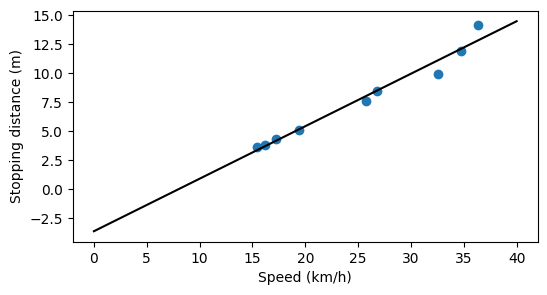

In [84]:
plt.figure(figsize=(6, 3))
plt.scatter(df['speed'], df['distance'])
plt.xlabel('Speed (km/h)')
plt.ylabel('Stopping distance (m)')
linear.plot_model(0, 40)

The linear model fits the data points well. Most points are close to the line, indicating a strong relationship.

### Sanity Checking the Model
Even though this linear model closely fits the data, there is a visible issue with the model, especially when considering the physics involved.

When an e-bike is not moving at all, it should take zero meters to stop. However, the model plot shows a negative stopping distance for zero speed.

To make it easier to visualize, let's add axis lines to our plot using the `axhline` and `axvline` methods.

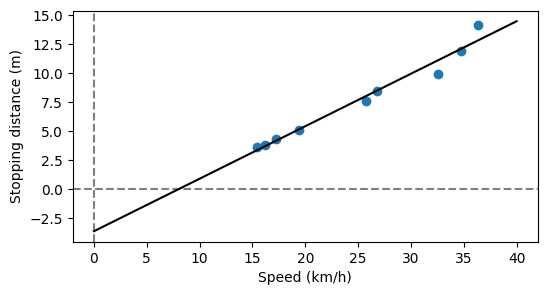

In [85]:
plt.figure(figsize=(6, 3))
plt.scatter(df['speed'], df['distance'])
plt.xlabel('Speed (km/h)')
plt.ylabel('Stopping distance (m)')
linear.plot_model(0,40)
plt.axhline(color='black', alpha=0.5, linestyle='--')
plt.axvline(color='black', alpha=0.5, linestyle='--')
plt.show()

Even though the model fits the data, it doesn’t pass our sanity check about what should happen at zero speed. Let's improve the modeling to account for this.

### Low Speed Data
Let's also include `ebike-data-low-speed.csv` to see if this low-speed data provides a better sense of what the relationship looks like near zero velocity.


In [86]:
df_low = pd.read_csv('ebike-data-low-speed.csv')
df_low #display the DataFrame

,speed,distance
0,0.0,0.00
1,2.0,0.04
2,3.0,0.10
3,5.0,0.20
4,7.0,0.33
5,8.0,0.86
6,10.0,1.50
7,11.0,1.79
8,13.0,2.26


This has data from speeds from 0 up to 13 km/h.

Let's plot this low speed data together with the original data. I'll use different colors so we can keep the datasets distinct.

In [87]:
def format_axes():
    plt.xlabel('Speed (km/h)')
    plt.ylabel('Stopping distance (m)')
    plt.axhline(color='black', alpha=0.5, linestyle='--')
    plt.axvline(color='black', alpha=0.5, linestyle='--')

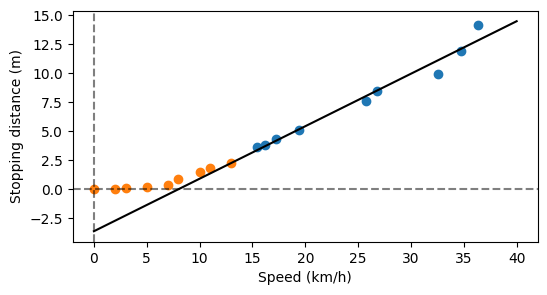

In [88]:
plt.figure(figsize=(6, 3))
plt.scatter(df['speed'], df['distance'], color='C0')
plt.scatter(df_low['speed'], df_low['distance'], color='C1')
linear.plot_model(0, 40)
format_axes()

The linear model does not fit the data well at low speeds, especially below 8 km/hr.

### Quadratic Model
The low-speed data shows us that the relationship isn't a straight line. It has some curvature to it. A quadratic curve is a common choice when modeling a moderate amount of curvature.

A quadratic equation is a second-degree polynomial of the form:

`y = ax² + bx + c`

Note: The equation for kinetic energy from physics (`KE = 1⁄2mv²`) is also quadratic. Since stopping needs to overcome kinetic energy, a quadratic model is a natural choice.

Here is the QuadraticModel python class I will use:

In [89]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

class QuadraticModel:
    def fit(self, x, y):
        x = pd.DataFrame(x)
        quadratic = PolynomialFeatures(degree=2)
        quad_features = quadratic.fit_transform(x)
        quad_model = LinearRegression().fit(quad_features, y)
        y_pred = quad_model.predict(quad_features)
        self.a = quad_model.coef_[2]
        self.b = quad_model.coef_[1]
        self.c = quad_model.intercept_
        self.rsquared = r2_score(y, y_pred)
        
    def predict(self, x):
        return self.a*x**2 + self.b*x + self.c
       
    def plot_model(self, xmin, xmax):
        xvals = range(xmin, xmax+1)
        yvals = [self.predict(x) for x in xvals]
        plt.plot(xvals, yvals, color='black')
        
    def print_model_info(self):
        a = self.a
        b = self.b
        c = self.c
        rsquared = self.rsquared
        print('QuadraticModel')
        print(f'Parameters: a = {a:.2f}, b = {b:.2f}, c = {c:.2f}')
        print(f'Equation: y = {self.a:.2f}x² + {self.b:.2f}x + {self.c:.2f}')
        print(f'Goodness of Fit (R²): {rsquared:.3f}')

Pandas has a `pd.concat()` method we can use to combine both df and df_low into a single DataFrame. This will allow us to fit the `QuadraticModel` to the full range of speeds.

In [90]:
df_all = pd.concat([df, df_low])
quadratic = QuadraticModel()
quadratic.fit(df_all['speed'], df_all['distance'])
quadratic.print_model_info()

QuadraticModel
Parameters: a = 0.01, b = 0.14, c = -0.43
Equation: y = 0.01x² + 0.14x + -0.43
Goodness of Fit (R²): 0.989


This model accounts for 98.9% of the variance in the data, which is an even better fit than what we saw with the linear model.

### Plot the Quadratic Model

Let's visualize how well our quadratic model follows the curve of the scatterplot.

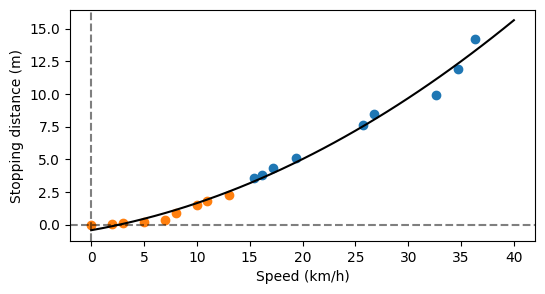

In [91]:
plt.figure(figsize=(6, 3))
plt.scatter(df['speed'], df['distance'], color='C0')
plt.scatter(df_low['speed'], df_low['distance'], color='C1')
quadratic.plot_model(0, 40)
format_axes()

The quadratic model provides a better fit than the linear model.

### Predicting High Speed Data

Let's also include some high-speed data: `ebike-data-high-speed.csv`.

In [92]:
df_high = pd.read_csv('ebike-data-high-speed.csv')
df_high

,speed,distance
0,38,14.35
1,39,15.09
2,42,17.74
3,42,15.75
4,42,17.61
...,...,...
10,56,24.51
11,58,34.31
12,59,30.01
13,61,31.59


This data goes up to speeds of 61 km/h.

Let's see how well our quadratic model can predict this new data that it wasn't trained on. Following code will plot the high speed data in green.

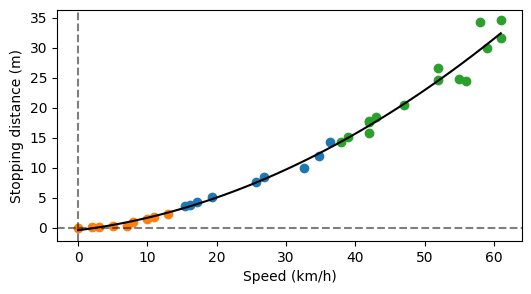

In [93]:
plt.figure(figsize=(6, 3))
plt.scatter(df['speed'], df['distance'], color='C0')
plt.scatter(df_low['speed'], df_low['distance'], color='C1')
plt.scatter(df_high['speed'], df_high['distance'], color='C2')
quadratic.plot_model(0, 61)
format_axes()

### Summary
In this project, I started with a linear model. While this provided a good fit for the initial data, it deviated from our physical intuition at zero speed.

I brought in some low-speed data and changed to a quadratic model. The quadratic model provided a better fit to the curved relationship.

Finally I tested my quadratic model on high-speed data, Using visual inspection of the graph, the model was able to predict the high-speed data with reasonable accuracy.